In [2]:
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

In [3]:
############################## DATA #######################################

In [4]:
# --- récupère les données
def getData(dataset):
    array = []
    for i in dataset[0]:
        try:
            array.append([i['a0'],i['a1']])
        except ValueError:
            array.append([i['x'],i['y']])
    return array

dataRef = (getData(loadarff(open("./donnees/2d-10c.arff",'r'))), 'Données de référence : 2d-10c',9)
dataNconvexe = (getData(loadarff(open("./donnees/rings.arff",'r'))), 'Données non convexes : rings',3)
dataMsep = (getData(loadarff(open("./donnees/elly-2d10c13s.arff",'r'))), 'Données mal séparées : elly-2d10c13s',10)
dataDens = (getData(loadarff(open("./donnees/sizes5.arff",'r'))), 'Données à densité variable : sizes5',4)
dataBruit = (getData(loadarff(open("./donnees/cure-t2-4k.arff",'r'))), 'Données bruitées : cure-t2-4k',7)


dataArray = [dataRef,dataNconvexe,dataMsep,dataDens,dataBruit]


In [5]:
########################## PLOT ############################################

In [6]:
# --- plot les données brutes
def plotNoColor(dataset):
    data = dataset[0]
    title = dataset[1]
    plt.figure(1)
    plt.title(title)
    for i in range(0,len(data)):
        plt.scatter(data[i][0],data[i][1],color='b')
        
    plt.show()
    

In [7]:
# --- plot les données avec une couleur associée à chaque cluster
intToCol = [[np.random.rand(3,)] for c in range(0,800)]

def plotColor(dataset, prediction):
    data = dataset[0]
    title = dataset[1]
    
    plt.figure(figsize=(5,3))
    
    for i in range(0,len(data)):
        col = intToCol[prediction[i]]
        plt.scatter(data[i][0],data[i][1],c=col)
    plt.title(title)
    plt.show()
    

In [8]:
###################### EVALUATION ####################################""""""

In [9]:
def evaluate_score(data,pred):   
    # entre -1 et +1, plus c'est haut, plus c'est dense et bien séparés
    # autour de 0, les clusters se chevauchent
    # plus haut pour les convexes
    try:
        val1 = silhouette_score(data,pred)
    except:
        val1 = None
    #print("silhouette: "+ str(val1))

    # plus c'est haut, plus c'est dense et bien séparés
    # plus haut pour les convexes
    try:
        val2 = calinski_harabasz_score(data, pred)
    except:
        val2 = None
    #print("calinski_harabasz : "+ str(val2))

    # plus bas possible = 0, plus proche de zero = mieux cluster
    # plus haut pour les convexes
    try:
        val3 = davies_bouldin_score(data, pred)
    except:
        val3 = None
    #print( "davies_bouldin : "+ str(val3))

    return (val1,val2,val3)

In [9]:
########################## DBSCAN ################################

In [31]:
from sklearn.cluster import DBSCAN

#effectue la prediction selon eps et min_sample sur data 
def dbscan_pred(eps,min_sample,data):

    dbscan = DBSCAN(eps=eps,min_samples=min_sample)

    # calcul le temps d'exe
    start = time.time()

    # training
    dbscan.fit(data)

    # prediction
    pred = dbscan.fit_predict(data)
    tmps = time.time()-start
    
    return (pred,tmps)


In [26]:

import plotly.express as px

from sklearn.neighbors import NearestNeighbors
#On utilise NearestNeighbors pour trouver la distance entre les points et leurs plus proches voisins

#Affiche la distance entre chaque point et son plus proche voisin, trié, afin d'estimer epsilon
def find_eps(data):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(data)
    distances, ids = nbrs.kneighbors(data)
    
    #sorting before plot
    distances = distances[:,1]
    distances = np.sort(distances, axis=0)
    
    a = px.scatter(y=distances, title='distance to closest point, ordered')
    a.show()

In [ ]:
#Try min_sample values
# test des parametres min_sample pour une valeur d'eps, affiche les différents indicateurs, à utiliser apres find_eps
'''from plotly.subplots import make_subplots
import plotly.graph_objects as go'''


def try_ms_values(data, eps, rgpar):
    sils = []
    cals = []
    davs = []
    tmps = []

    rg= range(*rgpar)
    
    for i in rg:
        pred,tmp = dbscan_pred(eps,i,data[0])
        sil,cal,dav = evaluate_score(data[0],pred)
        if sil is not None:
            sils.append(sil)
        else:
            sils.append(0)
        if cal is not None:
            cals.append(cal)
        else:
            cals.append(0)
        if dav is not None:
            davs.append(dav)
        else:
            davs.append(1)
        tmps.append(tmp)

    # plot 
    '''rglist = list(rg)
    fig = make_subplots(rows=4, cols=1)
    fig.add_trace(go.Figure(go.Scatter(x=rglist, y=sils)),row=1, col=1)
    fig.add_trace(go.Figure(go.Scatter(x=rglist, y=cals)),row=2, col=1)
    fig.add_trace(go.Figure(go.Scatter(x=rglist, y=davs)),row=3, col=1)
    fig.add_trace(go.Figure(go.Scatter(x=rglist, y=tmps)),row=4, col=1)'''
    plt.figure()

    fig,axs = plt.subplots(4, 1)
    axs[0].plot(rg,sils,'r')
    axs[0].set_title('Silhouette Coefficient selon min_sample')
    #plt.figure()
    axs[1].plot(rg,cals,'b')
    axs[1].set_title('Calinski-Harabasz Index selon min_sample')
    #plt.figure()
    axs[2].plot(rg,davs,'g')
    axs[2].set_title('Davies-Bouldin Index selon min_sample')
    #plt.figure()
    axs[3].plot(rg,tmps,'y')
    axs[3].set_title('Temps selon min_sample')

    plt.subplots_adjust(hspace=1.2, wspace=0.3) 

In [28]:

#Teste des range de parametres et conserve les predictions obtenant les meilleurs scores pour chaque indicateur
def find_and_display_best(dataA, epsminmaxstep, sampleminmaxstep, printemps = False):
    # test des parametres eps ET min-sample
    data = dataA[0]
    
    sils= []
    cals = []
    davs = []

    bestsilvalues = None
    bestsilpred = None
    bestsil = -100
    bestcalvalues = None
    bestcal = -100
    bestcalpred = None
    bestdavvalues = None
    bestdav = 100
    bestdavpred = None
    
    if isinstance(epsminmaxstep, float):
        arg = [epsminmaxstep,]
    else:
        arg = np.arange(*epsminmaxstep)
    
    for eps in arg:
        #print('eps = '+ str(eps))
        for min_sample in range(*sampleminmaxstep):
            
            #print('min-sample = '+ str(min_sample)) 
            
            pred,tmps = dbscan_pred(eps,min_sample,dataA[0])

            sil,cal,dav = evaluate_score(dataA[0],pred)
            #sils.append(sil)
            #cals.append(cal)
            #davs.append(dav)
            #print('sil : '+ str(sil))
            #print('cal : '+ str(cal))
            #print('dav : '+ str(dav))
            if printemps:
                print(tmps)

            if sil is not None and sil>bestsil:
                bestsilvalues = (eps,min_sample)
                bestsil = sil
                bestsilpred = pred

            if cal is not None and cal>bestcal:
                bestcalvalues = (eps,min_sample)
                bestcal = cal
                bestcalpred = pred
                
            if dav is not None and dav<bestdav:
                bestdavvalues = (eps,min_sample)
                bestdav = dav
                bestdavpred = pred
                
    print('best values according to silhouette:')
    print(str(bestsilvalues) + ' with an index of ' + str(bestsil))
    plotColor(dataA,bestsilpred)
    
    print('best values according to Calinski-Harasbasz:')
    print(str(bestcalvalues) + ' with an index of ' + str(bestcal))
    plotColor(dataA,bestcalpred)
    
    print('best values according to Davies-Bouldin')
    print(str(bestdavvalues) + ' with an index of ' + str(bestdav))
    plotColor(dataA,bestdavpred)

In [ ]:
#tests pour données de référence

In [111]:
find_eps(dataRef[0])

<Figure size 432x288 with 0 Axes>

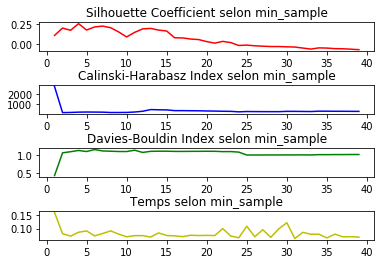

In [72]:
try_ms_values(dataRef,0.68, (1,40))

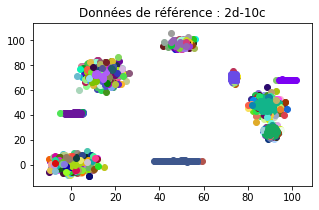

In [78]:
pred,tmps = dbscan_pred(0.68,1,dataRef[0])

plotColor(dataRef,pred)

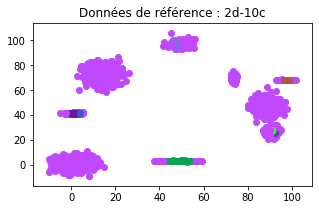

In [79]:
pred,tmps = dbscan_pred(0.68,25,dataRef[0])

plotColor(dataRef,pred)

eps = 0.74
best values according to silhouette:
(0.74, 3) with an index of 0.3487319896594759


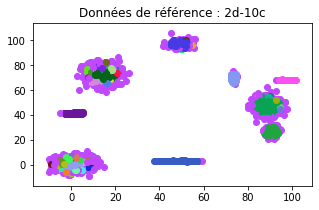

best values according to Calinski-Harasbasz:
(0.74, 1) with an index of 2852.654459978938


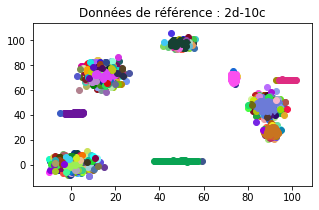

best values according to Davies-Bouldin
(0.74, 1) with an index of 0.4332107639438031


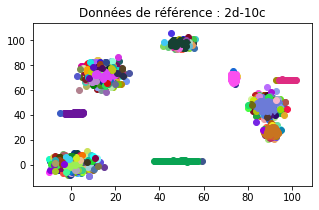

In [74]:
find_and_display_best(dataRef,0.74,(1,20,1))

In [ ]:
#Tests pour données non convexes

In [86]:
find_eps(dataNconvexe[0],20)

best values according to silhouette:
(2.000000000000001, 9) with an index of 0.4340255656254122


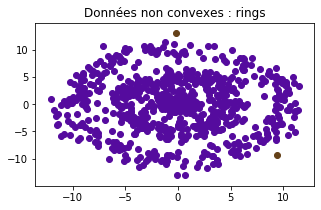

best values according to Calinski-Harasbasz:
(1.5000000000000004, 8) with an index of 163.12165310156144


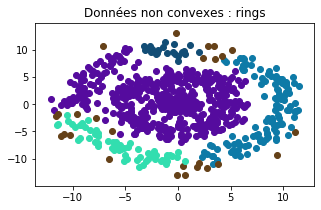

best values according to Davies-Bouldin
(2.000000000000001, 5) with an index of 0.39118358456260727


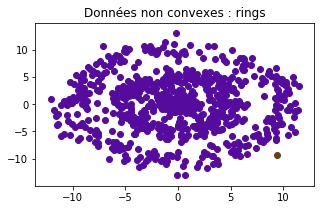

In [32]:
#test rings
#find_and_display_best(dataNconvexe,(0.2,20,0.2),(1,40,2))
find_and_display_best(dataNconvexe,(1.0,4.0,0.1),(5,15,1), False)

In [ ]:
#Rien de concluant, essayons de trouver a la main pres des valeurs trouvées par Calinski

<Figure size 432x288 with 0 Axes>

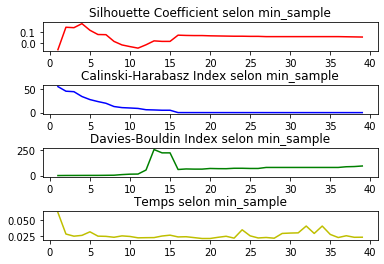

In [81]:
try_ms_values(dataNconvexe,0.70, (1,40))

In [ ]:
#Tests pour données bruitées

eps = 0.05
sil : -0.3079510343112612
cal : 205.78563547462377
dav : 1.577763536588693
sil : -0.050540586522231125
cal : 785.2670797839871
dav : 1.5291942052264282
sil : 0.16439584603198018
cal : 1685.0794238151943
dav : 1.3841677244836947
sil : -0.015437215653531532
cal : 1081.9062525202576
dav : 1.6369962601158177
sil : 0.03881615622166472
cal : 435.01865238961926
dav : 2.005962200636593
sil : 0.09457537495562092
cal : 295.46006048365956
dav : 2.3089607453420333
sil : 0.019128527431158542
cal : 357.6882599695003
dav : 1.36576181629849
sil : -0.07935796889649727
cal : 421.61207139264866
dav : 1.392270682579003
sil : -0.049597539470453256
cal : 657.3360894156644
dav : 1.0954830447805244
sil : -0.061897210782256094
cal : 375.58404476541347
dav : 0.8662127525447393
sil : 0.15106989253776476
cal : 291.0829708273264
dav : 0.7420595649617826
sil : 0.03988457210136479
cal : 268.056617154109
dav : 0.8768566673640854
eps = 0.1
sil : -0.25139730721598663
cal : 5.882353347505759
dav : 2.231668337

sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
eps = 0.8500000000000001
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
eps = 0.9000000000000001
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav : None
sil : None
cal : None
dav 

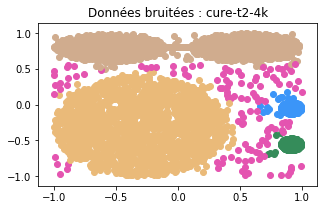

best values according to Calinski-Harasbasz:
(0.1, 10) with an index of 2180.5870933036235


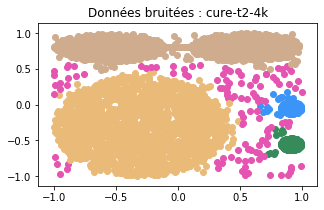

best values according to Davies-Bouldin
(0.2, 8) with an index of 0.6517638223560038


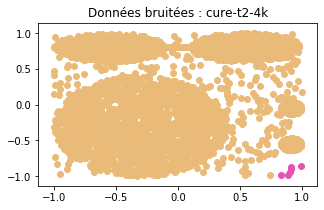

In [18]:
find_and_display_best(dataBruit,(0.05,1.0,0.05),(2,25,2))

eps = 0.01
eps = 0.02
eps = 0.03
eps = 0.04
eps = 0.05
eps = 0.060000000000000005
eps = 0.06999999999999999
eps = 0.08
eps = 0.09
eps = 0.09999999999999999
eps = 0.11
eps = 0.12
eps = 0.13
eps = 0.14
eps = 0.15000000000000002
eps = 0.16
eps = 0.17
eps = 0.18000000000000002
eps = 0.19
eps = 0.2
eps = 0.21000000000000002
eps = 0.22
eps = 0.23
eps = 0.24000000000000002
eps = 0.25
eps = 0.26
eps = 0.27
eps = 0.28
eps = 0.29000000000000004
eps = 0.3
eps = 0.31
eps = 0.32
eps = 0.33
eps = 0.34
eps = 0.35000000000000003
eps = 0.36000000000000004
eps = 0.37
eps = 0.38
eps = 0.39
eps = 0.4
eps = 0.41000000000000003
eps = 0.42000000000000004
eps = 0.43
eps = 0.44
eps = 0.45
eps = 0.46
eps = 0.47000000000000003
eps = 0.48000000000000004
eps = 0.49
best values according to silhouette:
(0.12, 12) with an index of 0.4310173543278648


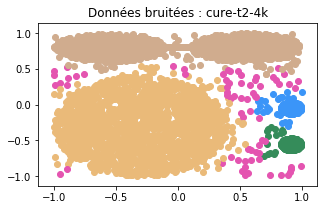

best values according to Calinski-Harasbasz:
(0.12, 12) with an index of 2202.0129397323562


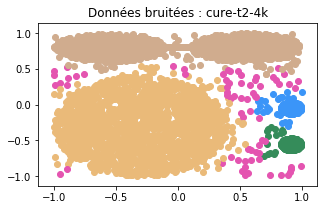

best values according to Davies-Bouldin
(0.21000000000000002, 8) with an index of 0.6026716336887091


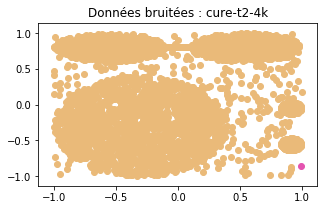

In [26]:
find_and_display_best(dataBruit,(0.01,0.5,0.01),(2,15,2))

In [119]:
find_eps(dataBruit[0])

best values according to silhouette:
(0.03, 16) with an index of 0.07985306577345005


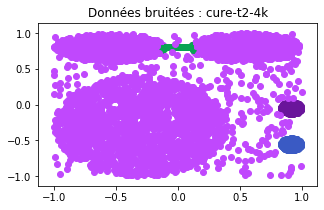

best values according to Calinski-Harasbasz:
(0.03, 16) with an index of 730.7739364908017


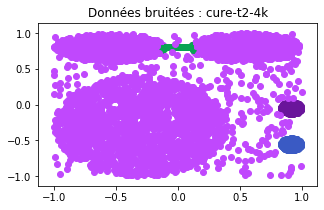

best values according to Davies-Bouldin
(0.03, 1) with an index of 0.7836256793770653


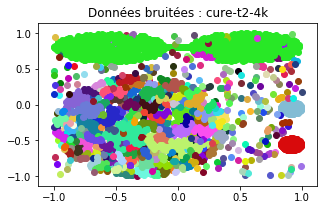

In [124]:
find_and_display_best(dataBruit,0.03,(1,20,1))

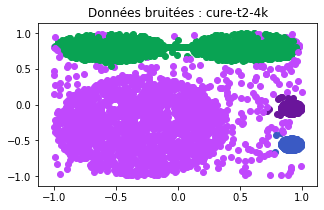

In [98]:
#tests individuels
pred,tmps = dbscan_pred(0.1,60,dataBruit[0])

plotColor(dataBruit,pred)

In [ ]:
#Tests pour mal séparés

best values according to silhouette:
(0.2, 10) with an index of 0.3677788693537026


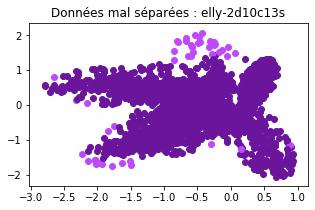

best values according to Calinski-Harasbasz:
(0.1, 16) with an index of 305.73910682256917


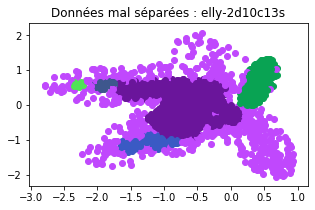

best values according to Davies-Bouldin
(0.30000000000000004, 12) with an index of 0.454744911631977


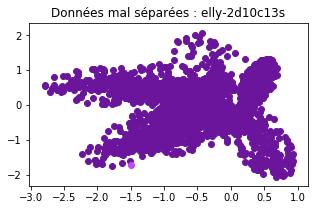

In [99]:
find_and_display_best(dataMsep,(0.1,10,0.1),(2,25,2))

eps = 0.05
eps = 0.1
eps = 0.15000000000000002
eps = 0.2
eps = 0.25
eps = 0.3
eps = 0.35000000000000003
eps = 0.4
eps = 0.45
eps = 0.5
eps = 0.55
eps = 0.6000000000000001
eps = 0.6500000000000001
eps = 0.7000000000000001
eps = 0.7500000000000001
eps = 0.8
eps = 0.8500000000000001
eps = 0.9000000000000001
eps = 0.9500000000000001
best values according to silhouette:
(0.2, 10) with an index of 0.3677788693537026


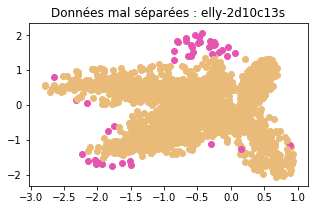

best values according to Calinski-Harasbasz:
(0.1, 16) with an index of 305.73910682256917


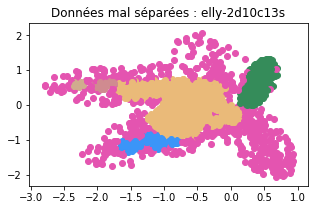

best values according to Davies-Bouldin
(0.3, 12) with an index of 0.454744911631977


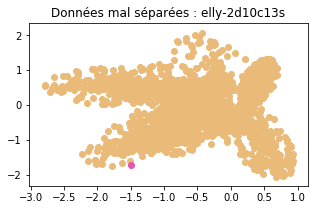

In [23]:
find_and_display_best(dataMsep,(0.05,1.0,0.05),(2,25,2))

In [114]:
find_eps(dataMsep[0])

IndexError: index 2796 is out of bounds for axis 0 with size 2796

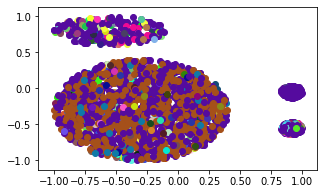

In [33]:
#tests individuels
pred,tmps = dbscan_pred(0.07,1,dataMsep[0])

plotColor(dataBruit,pred)

In [ ]:
#Tests pour densité variable

best values according to silhouette:
(2.9, 18) with an index of 0.5701041745532874


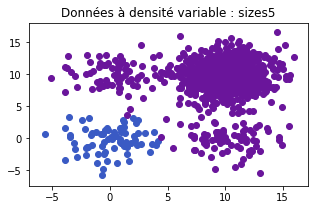

best values according to Calinski-Harasbasz:
(1.55, 24) with an index of 695.6537946314494


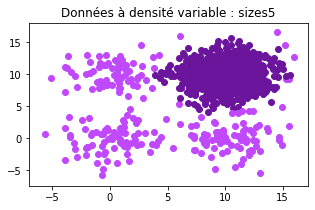

best values according to Davies-Bouldin
(2.1999999999999997, 2) with an index of 0.33162876911864514


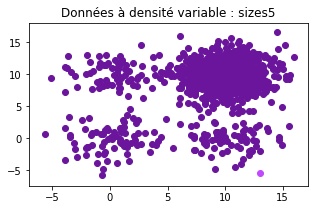

In [126]:
find_and_display_best(dataDens,(0.05,3.0,0.05),(2,25,2))

In [ ]:
def display_some(dataA, epsminmaxstep, sampleminmaxstep):
    # test des parametres eps ET min-sample
    data = dataA[0]
    
    for eps in np.arange(*epsminmaxstep):
        print('eps = '+ str(eps))
        for min_sample in range(*sampleminmaxstep):
            
            #print('min-sample = '+ str(min_sample)) 
            
            pred,tmps = dbscan_pred(eps,min_sample,dataRef[0])

In [ ]:
## rq : faire une courbe des scores en fonction des valeurs de eps et min-range pour plus de clarete

def find_param_dbscan(data):


    rng_eps = np.arange(1.0,10.0,1.0)
    rng_min_sample = range(1,15,1)
    
    for eps in rng_eps:
        sil = []
        cal = []
        dav = []
        tmps = []
        for min_sample in rng_min_sample:
            # predit avec des valeur de min et eps
            pred,tmp = dbscan_pred(eps,min_sample,data)
            tmps.append(tmp)
            
            # evalue
            a,b,c = evaluate_score(data,pred)
            sil.append(a)
            cal.append(b)
            dav.append(c)
       
        # plot 
        plt.figure()
        fig,axs = plt.subplots(4, 1)
        axs[0].plot(rng_min_sample,sil,'r')
        axs[0].set_title('Eps : ' + str(eps) + ' pour sil')
        #plt.figure()
        axs[1].plot(rng_min_sample,cal,'b')
        axs[1].set_title('Eps : ' + str(eps) + ' pour cal')
        #plt.figure()
        axs[2].plot(rng_min_sample,dav,'g')
        axs[2].set_title('Eps : ' + str(eps) + ' pour dav')
        #plt.figure()
        axs[3].plot(rng_min_sample,tmps,'y')
        axs[3].set_title('Eps : ' + str(eps) + ' temps')


#https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html


In [ ]:
find_param_dbscan(dataRef[0])
# ajouter le nom de chaque courbe

In [ ]:
# meilleure combinaison : min-sample = 10 et eps = 4
# application a tous les dataset

for data in dataArray:
    print(data[1])
    find_param_dbscan(data[0])


In [ ]:
################################## HDBSCAN ###################################

In [10]:
import hdbscan
import time 

#prediction, version hdbscan
def hdbscan_pred(data,min_samples=None, min_cluster_size= None):
    # parametres pour le kmeans
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size = min_cluster_size)

    # calcul le temps d'exe
    start = time.time()

    # training
    clusterer.fit(data)

    # prediction
    pred = clusterer.fit_predict(data)
    tmps = time.time()-start
    
    return (pred,tmps)

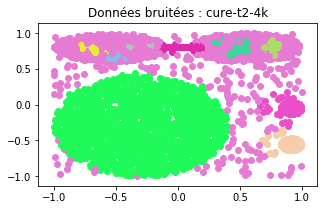

In [10]:

pred,tmps = hdbscan_pred(dataBruit[0], 40,20 )
plotColor(dataBruit, pred)


In [20]:
#recherche de parametres, version hdbscan

def find_and_display_best2(dataA, aminsa, aminclu, printemps = False):
    # test des parametres eps ET min-sample
    data = dataA[0]
    
    sils= []
    cals = []
    davs = []

    bestsilvalues = None
    bestsilpred = None
    bestsil = -100
    bestcalvalues = None
    bestcal = -100
    bestcalpred = None
    bestdavvalues = None
    bestdav = 100
    bestdavpred = None
    
    if isinstance(aminsa, int):
        arg = [aminsa,]
    else:
        arg = range(*aminsa)
    
    if isinstance(aminclu, int):
        arg2 = [aminclu,]
    else:
        arg2 = range(*aminclu)
    
    for minsa in arg:
        #print('eps = '+ str(eps))
        for minclu in arg2:
            
            #print('min-sample = '+ str(min_sample)) 
            
            pred,tmps = hdbscan_pred(dataA[0],minsa,minclu)

            sil,cal,dav = evaluate_score(dataA[0],pred)
            #sils.append(sil)
            #cals.append(cal)
            #davs.append(dav)
            #print('sil : '+ str(sil))
            #print('cal : '+ str(cal))
            #print('dav : '+ str(dav))

            
            if printemps:
                print(tmps)

            if sil is not None and sil>bestsil:
                bestsilvalues = (minsa,minclu)
                bestsil = sil
                bestsilpred = pred

            if cal is not None and cal>bestcal:
                bestcalvalues = (minsa,minclu)
                bestcal = cal
                bestcalpred = pred
                
            if dav is not None and dav<bestdav:
                bestdavvalues = (minsa,minclu)
                bestdav = dav
                bestdavpred = pred
                
    print('best values according to silhouette:')
    print(str(bestsilvalues) + ' with an index of ' + str(bestsil))
    plotColor(dataA,bestsilpred)
    
    print('best values according to Calinski-Harasbasz:')
    print(str(bestcalvalues) + ' with an index of ' + str(bestcal))
    plotColor(dataA,bestcalpred)
    
    print('best values according to Davies-Bouldin')
    print(str(bestdavvalues) + ' with an index of ' + str(bestdav))
    plotColor(dataA,bestdavpred)

In [ ]:
#tests données bruitées

best values according to silhouette:
(5, 9) with an index of 0.21671265794973474


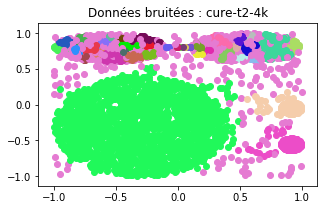

best values according to Calinski-Harasbasz:
(10, 10) with an index of 674.6545986973579


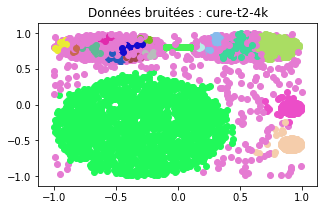

best values according to Davies-Bouldin
(2, 5) with an index of 1.3384978585286371


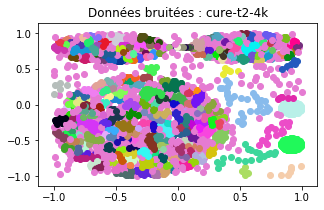

In [14]:
find_and_display_best2(dataBruit, (2,11,1), (2,11,1))

best values according to silhouette:
(6, 34) with an index of 0.2512540435575123


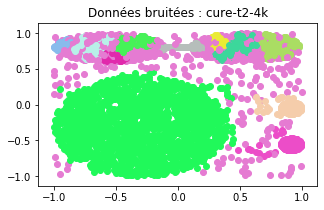

best values according to Calinski-Harasbasz:
(26, 18) with an index of 1313.68564962061


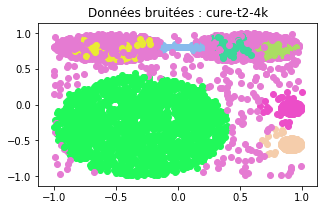

best values according to Davies-Bouldin
(2, 2) with an index of 1.4099079069802283


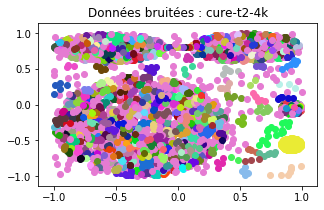

In [15]:
find_and_display_best2(dataBruit, (2,40,4), (2,40,4))

best values according to silhouette:
(1, 80) with an index of 0.3455146490066568


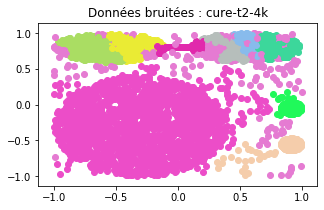

best values according to Calinski-Harasbasz:
(1, 80) with an index of 1644.2904607347946


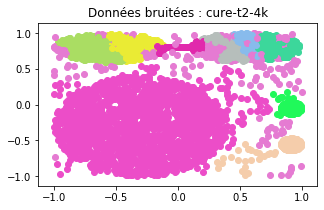

best values according to Davies-Bouldin
(1, 80) with an index of 1.4205274782033344


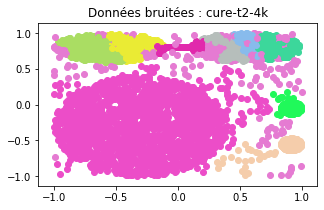

In [16]:
find_and_display_best2(dataBruit, (1,40,4), (40,84,4))

best values according to silhouette:
(45, 2) with an index of 0.42840056451711483


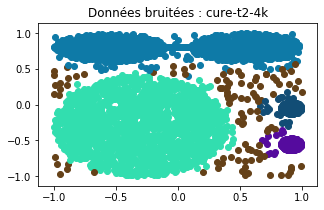

best values according to Calinski-Harasbasz:
(57, 2) with an index of 2215.574824088955


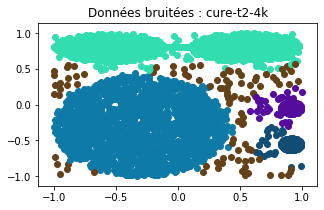

best values according to Davies-Bouldin
(1, 22) with an index of 1.3580503597489526


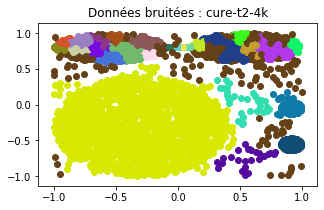

In [15]:
find_and_display_best2(dataBruit, (1,100,4), (2,100,4))

In [ ]:
#tests densité variable

0.19562673568725586
0.11723017692565918
0.1469728946685791
0.10693192481994629
0.13411211967468262
0.11831951141357422
0.1668086051940918
0.10860300064086914
0.16659021377563477
0.2545044422149658
0.15769696235656738
0.15238070487976074
0.13435816764831543
0.1379532814025879
0.12558984756469727
0.1667804718017578
0.13747096061706543
0.15912199020385742
0.1567680835723877
0.13725543022155762
0.15949654579162598
0.11944293975830078
0.14672207832336426
0.12795591354370117
0.16422009468078613
0.13330745697021484
0.2629733085632324
0.30789852142333984
0.15529179573059082
0.17291855812072754
0.14910578727722168
0.14490556716918945
0.11302781105041504
0.14284253120422363
0.14253687858581543
0.26946067810058594
0.3435349464416504
0.23075008392333984
0.23640894889831543
0.13048458099365234
0.16797184944152832
0.11463260650634766
0.18218588829040527
0.12179160118103027
0.1634693145751953
0.1340038776397705
0.1460411548614502
0.14638710021972656
0.14998602867126465
0.1744377613067627
0.2482793331

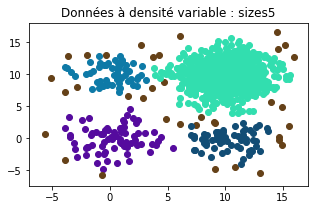

best values according to Calinski-Harasbasz:
(2, 10) with an index of 536.7911176085006


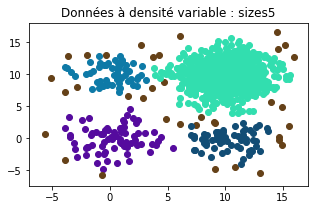

best values according to Davies-Bouldin
(34, 2) with an index of 1.3743180704597175


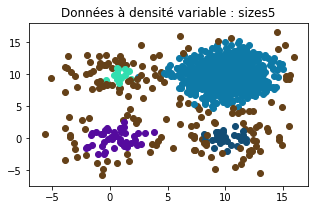

In [23]:
find_and_display_best2(dataDens, (2,40,4), (2,40,4), True)